# Multi-label image classification

What if we have images for which we want to potentially assign a variable number of categories?

## The Pascal dataset

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
path

Path('/home/jupyter/.fastai/data/pascal_2007')

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#8) [Path('test.csv'),Path('valid.json'),Path('train.csv'),Path('segmentation'),Path('train.json'),Path('test.json'),Path('train'),Path('test')]

This dataset has a `.csv` with the labels for each image

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## Constructing a data block

PyTorch and fastai have two main classes for representing and accessing a training/validation set:

- `Dataset`: a collection which returns a tuple of your independent and dependent variable for a single item
- `DataLoader`: an iterator which provides a stream of mini-batches, where each mini-batch is a couple of a batch of independent variables and a batch of dependent variables

For example, the following is a valid example of a `Dataset`

In [7]:
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

And the following is a valid example of a `DataLoader`

In [8]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a) # a mini-batch
b

(tensor([18,  9, 17,  6, 12, 25,  0, 21]),
 ('s', 'j', 'r', 'g', 'm', 'z', 'a', 'v'))

To see how the elements of the independent and dependent variables correspond to each other, we can use `zip`

In [11]:
list(zip(b[0], b[1]))

[(tensor(18), 's'),
 (tensor(9), 'j'),
 (tensor(17), 'r'),
 (tensor(6), 'g'),
 (tensor(12), 'm'),
 (tensor(25), 'z'),
 (tensor(0), 'a'),
 (tensor(21), 'v')]

In [12]:
list(zip(*b)) # destructure b using *. zip(*x) is like transposing an object from one orientation to another

[(tensor(18), 's'),
 (tensor(9), 'j'),
 (tensor(17), 'r'),
 (tensor(6), 'g'),
 (tensor(12), 'm'),
 (tensor(25), 'z'),
 (tensor(0), 'a'),
 (tensor(21), 'v')]

On top of `Dataset` and `DataLoader`, we also have the following classes for bringing training and validation sets together
- `Datasets`: An object which contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`: An object which contains a training `DataLoader` and a validation `DataLoader`

Since a `DataLoader` builds on top of a `Dataset` and adds functionality to it (collaging multiple items into a mini-batch), it's often easiest to start my creating and testing `Datasets`, and then look at `DataLoaders` after that's working

Normally we don't begin with tuples of independent and dependent variables. Usually we have to perform some kind of extraction/transformation in order to get these in one place. For example:

In [13]:
a = list(string.ascii_lowercase)

In [14]:
dss = Datasets(a)
dss[0]

('a',)

In practice, what we really want to do is take this, and do something to compute an independent and dependent variables

In [20]:
def f1(o): return o+'a'  # independent variable
def f2(o): return o+'b'  # dependent variable

In [21]:
dss = Datasets(a, [[f1]])
dss[0]

('aa',)

In [22]:
dss = Datasets(a, [[f1, f2]])
dss[0]

('aab',)

In [23]:
dss = Datasets(a, [[f1], [f2]])
dss[0]

('aa', 'ab')

This is what we want. **This is the main way we build up independent and dependent variables into a `DataSets` object in fastai**. E.g. for image classification

- `f1`: open up image
- `f2`: parse file name

In [25]:
dls = DataLoaders.from_dsets(dss, batch_size=4)

In [28]:
b = first(dls.train)
b

(('xa', 'ka', 'qa', 'oa'), ('xb', 'kb', 'qb', 'ob'))

### Creating a `DataBlock` for the Pascal dataset

We often don't need to do this from scratch, however. We can create a `DataBlock` to do the above processes for us. It's a good idea to build a `DataBlock` up step-by-step to understand what each step is doing.

Let's start with the simplest case, which is an empty `DataBlock`

In [29]:
dblock = DataBlock()

We can create a `Datasets` object from this. The only thing needed is a source. In thiscase, our dataframe:

In [30]:
dsets = dblock.datasets(df)

We can see that the method has already made a training and validation set for us 

In [31]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

But it hasn't done it using the `is_valid` column

In [32]:
df.shape[0] - df.is_valid.sum(), df.is_valid.sum()

(2501, 2510)

In [34]:
x,y = dsets.train[0]

In [35]:
x

fname       007285.jpg
labels             car
is_valid         False
Name: 3681, dtype: object

In [36]:
y

fname       007285.jpg
labels             car
is_valid         False
Name: 3681, dtype: object

By default, the independent and dependent variables have been set to be idential. That's not what we want. Instead we want this:

In [39]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)

In [41]:
dsets.train[2]

('001727.jpg', 'horse person')

We've used a lambda function here to iterate quickly, but unfortunately lambdas are not compatible with serialization, which means we won't be able to export our `Learner` if we use a lambda. So we need to more verbose functions

In [56]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

We don't get the same answer because it's using different random splits for the validation set each time we call the `DataBlock` API.

In [58]:
dsets.train[2]

(Path('train/006532.jpg'), ['motorbike', 'person'])

We want the path above to be opened as an image, so the `DataBlock` API has a `blocks` argument to specify the type for the independent and dependent variables

In [59]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y
                  )
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x379,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

In [62]:
dsets.vocab

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [66]:
idxs = torch.where(dsets.train[0][1]==1.)

In [68]:
dsets.vocab[idxs[0]]

(#2) ['bus','person']

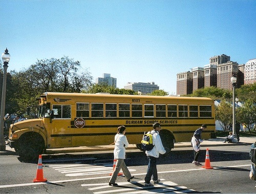

In [61]:
dsets.train[0][0].to_thumb(256)

The dependent variable has been converted from a list of strings to a one-hot encoded vector.

The `DataBlock` uses a random split by default. We are given an `is_valid` column in our dataframe, so let's use that instead

In [69]:
def splitter(df):  # takes as an argument what you give to dblock.datasets
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [71]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x, get_y = get_y
                  )
dsets = dblock.datasets(df)

In [72]:
df.shape[0] - df.is_valid.sum(), df.is_valid.sum()

(2501, 2510)

In [73]:
len(dsets.train), len(dsets.valid)

(2501, 2510)

The images are all of different sizes. We can use `item_tfms` and `RandomResizedCrop` to fix this. We're now ready to collate the items into `DataLoaders`, as each item looks ok.

In [75]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x, 
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35)
                  )
dls = dblock.dataloaders(df)  # instead of datasets, because each item is now working ok

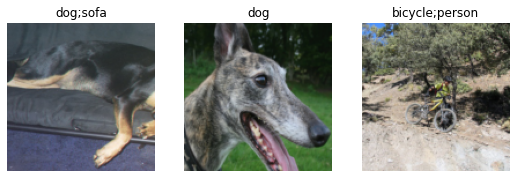

In [76]:
dls.show_batch(nrows=1, ncols=3)

In [80]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': (#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...], 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    

## Binary cross entropy